# Visualising taxa abundance

In [44]:
setwd("/mnt/c/Users/Cedric/Desktop/git_repos/blood_microbiome")
require(tidyverse)
require(ggplot2)
require(data.table)
require(egg)
require(foreach)

Loading required package: foreach


Attaching package: ‘foreach’


The following objects are masked from ‘package:purrr’:

    accumulate, when




In [2]:
meta <- fread("data/SG10K_Health_metadata.n10714.16March2021.parsed.csv")
head(meta)

npm_research_id,multiplex_pool_id,supplier_id,gis_internal_sample_id,site_supplying_sample,year_of_birth,supplied_gender,self_reported_ethnicity,extraction_kit,date_of_dna_extraction,⋯,supplied_and_computed_gender_match,sop_agreement_for_coverage__14/_28_for_15x/30x,sample_life_cycle,current,source_cohort,original_supplier_id,duplicate_info,duplicate,duplicate_pair,removal_requested_by_supplier
<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
WHB10000,MUX9693,00358,HELIOS_00358_1,HELIOS,1982,F,Chinese,abGENIX Whole Blood Genomic DNA Extraction Kit,6/6/2019,⋯,Y,Y,HELIOS VCF,Y,HELIOS,00358,Unknown,PASS,Unknown,Unknown
WHB10001,MUX9693,00359,HELIOS_00359_1,HELIOS,1979,F,Chinese,abGENIX Whole Blood Genomic DNA Extraction Kit,6/6/2019,⋯,Y,Y,HELIOS VCF,Y,HELIOS,00359,Unknown,PASS,Unknown,Unknown
WHB10002,MUX9695,00360,HELIOS_00360_1,HELIOS,1970,F,Chinese,abGENIX Whole Blood Genomic DNA Extraction Kit,6/6/2019,⋯,Y,N,HELIOS VCF,Y,HELIOS,00360,Unknown,PASS,Unknown,Unknown
WHB10003,MUX9694,00361,HELIOS_00361_1,HELIOS,1969,M,Chinese,abGENIX Whole Blood Genomic DNA Extraction Kit,6/6/2019,⋯,Y,Y,HELIOS VCF,Y,HELIOS,00361,Unknown,PASS,Unknown,Unknown
WHB10005,MUX9694,00363,HELIOS_00363_1,HELIOS,1959,F,Chinese,abGENIX Whole Blood Genomic DNA Extraction Kit,6/6/2019,⋯,Y,N,HELIOS VCF,Y,HELIOS,00363,Unknown,PASS,Unknown,Unknown
WHB10006,MUX9694,00364,HELIOS_00364_1,HELIOS,1955,F,Chinese,abGENIX Whole Blood Genomic DNA Extraction Kit,6/6/2019,⋯,Y,Y,HELIOS VCF,Y,HELIOS,00364,Unknown,PASS,Unknown,Unknown


## Pre-process data

In [3]:
load_data <- function(file_path) {
    df <- fread(file_path) %>%
        separate(sample, into = c(NA, "npm_research_id"), sep = "\\.")
    return(df)
}

rank <- "S"
n_subset <- 9999

species_df <- load_data(str_glue("data/temp_files_{n_subset}/07_abundance_matrix/abundance_matrix.subset_{n_subset}.{rank}.tsv"))

rank <- "G"
genus_df <- load_data(str_glue("data/temp_files_{n_subset}/07_abundance_matrix/abundance_matrix.subset_{n_subset}.{rank}.tsv"))


## Distribution of microbial reads per sample

Warning message:
“Removed 54 rows containing non-finite values (stat_bin).”


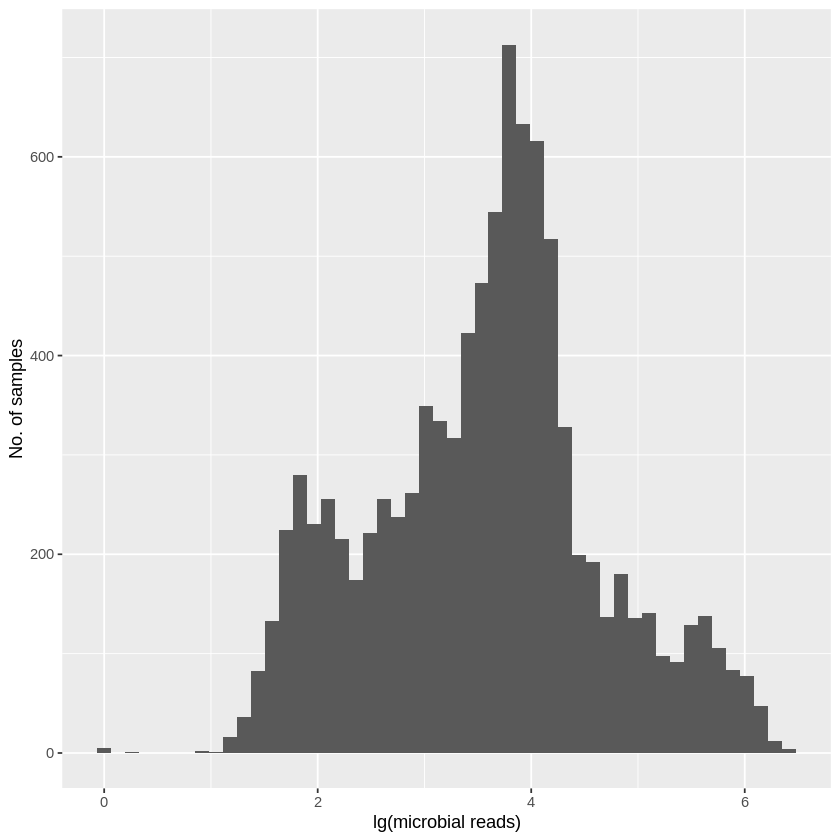

In [33]:
read_counts <- apply(genus_df %>% select(-npm_research_id, -unclassified, -Homo), 1, sum)

genus_reads <- genus_df %>% 
    select(-unclassified, -Homo) %>%
    mutate(total = rowSums(across(where(is.numeric))))
    
genus_reads %>% 
    ggplot(aes(x = log(total, base = 10))) +
    geom_histogram(bins = 50) +
    labs(x = "lg(microbial reads)", y = "No. of samples")

## Choosing microbial read per sample threshold

In [49]:
n_left <- c()
t_vec <- seq(1, 1000, 10)

morsels <- foreach (t = t_vec) %do% {
    tmp <- genus_reads %>% 
        filter(total > t)
    
    morsel <- tibble(t = t, n_left = nrow(tmp))
    return(morsel)
}

head(bind_rows(morsels))


t,n_left
<dbl>,<int>
1,9647
11,9644
21,9607
31,9517
41,9396
51,9268


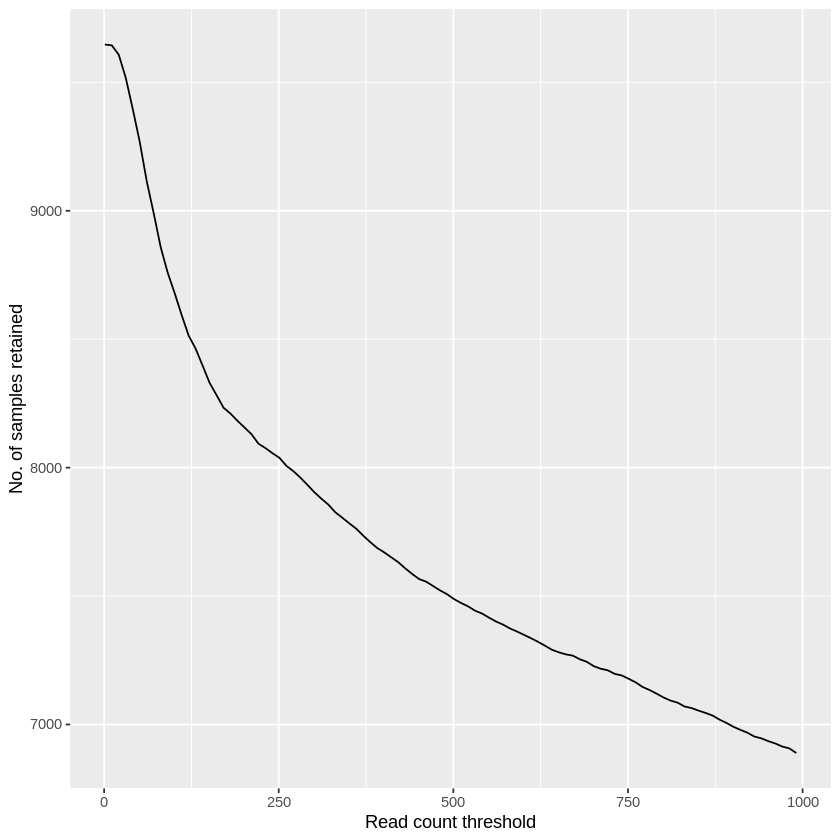

In [51]:
bind_rows(morsels) %>% 
    ggplot(aes(x = t, y = n_left)) +
    geom_line() +
    labs(x = "Read count threshold", y = "No. of samples retained")

Joining, by = "npm_research_id"

Warning message:
“Removed 54 rows containing non-finite values (stat_boxplot).”


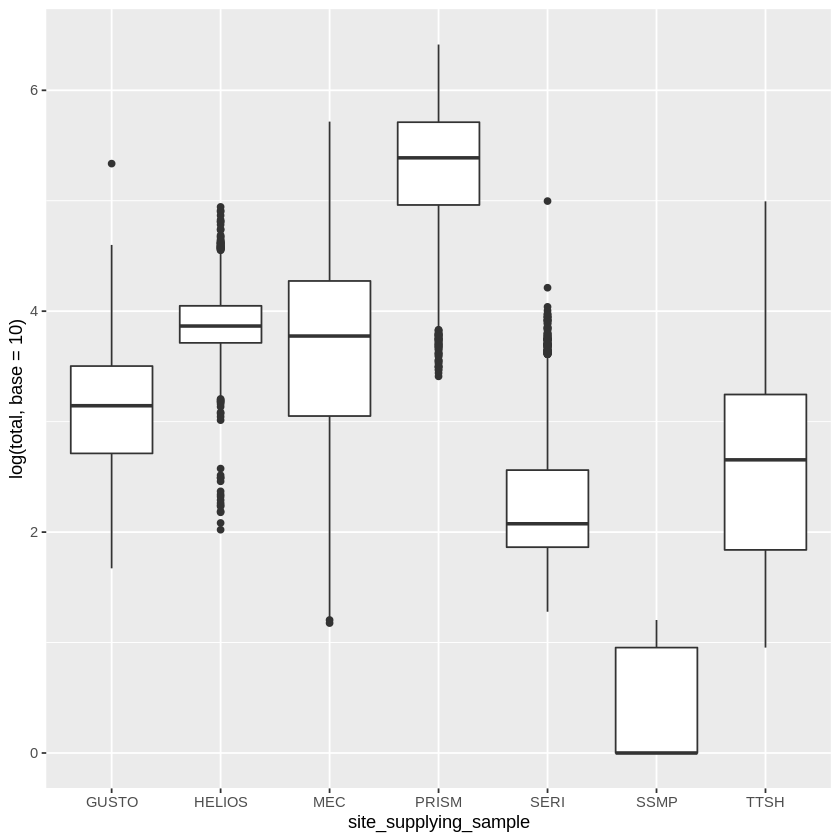

In [65]:
genus_reads %>%
    left_join(meta) %>%
    ggplot(aes(x = site_supplying_sample, y = log(total, base = 10))) +
    geom_boxplot()

In [70]:
# t <- 500
t <- quantile(genus_reads$total, 0.1)[[1]]
to_retain <- genus_reads %>% 
    filter(total > t) %>%
    select(npm_research_id)

nrow(to_retain)
fwrite(to_retain, str_glue("data/samples_above_{t}_reads.txt"))

[1] 8728

Joining, by = "npm_research_id"

Joining, by = "npm_research_id"

Warning message:
“Removed 54 rows containing non-finite values (stat_boxplot).”


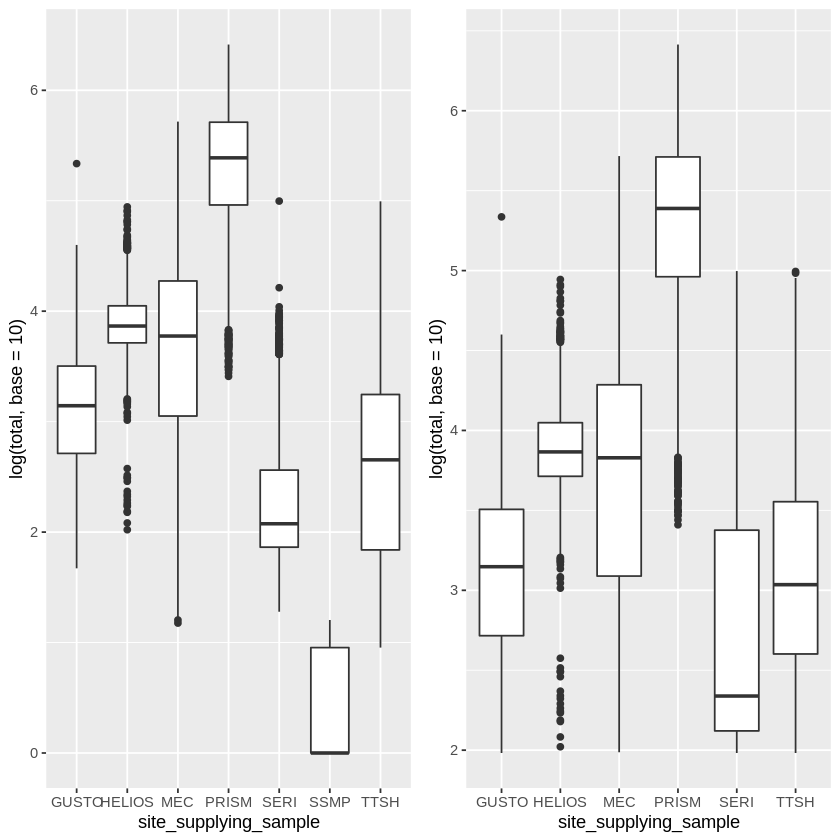

In [75]:
before <- genus_reads %>%
    left_join(meta) %>%
    ggplot(aes(x = site_supplying_sample, y = log(total, base = 10))) +
    geom_boxplot()

after <- genus_reads %>%
    left_join(meta) %>%
    filter(npm_research_id %in% to_retain$npm_research_id) %>%
    ggplot(aes(x = site_supplying_sample, y = log(total, base = 10))) +
    geom_boxplot()


ggarrange(before, after, ncol = 2)

#### Distribution of read counts

In [4]:
otu_to_RA <- function(df) {
    row_names <- df$npm_research_id
    RA_df <- t(apply(df[, 2:ncol(df)], 1, function(x) {x / sum(x)}))
    
    return(cbind(data.frame(npm_research_id = row_names), as.data.frame(RA_df, check.names = F)))
}

species_RA <- otu_to_RA(species_df)
genus_RA <- otu_to_RA(genus_df)

no_microbes <- genus_RA

In [5]:
prev_genus <- genus_RA[, 2:ncol(genus_RA)]
prev_genus[prev_genus > 0] <- 1
prev_genus$npm_research_id <- genus_RA$npm_research_id

In [16]:
col <- "site_supplying_sample"
test <- prev_genus %>% 
    left_join(meta) %>%
    group_by_at(c(col)) %>%
    summarise(sum = sum(Bradyrhizobium))

test %>% mutate(prevalence = sum / as.vector(table(meta[, ..col])))

Joining, by = "npm_research_id"



site_supplying_sample,sum,prevalence
<chr>,<dbl>,<dbl>
GUSTO,968,1.00000000
HELIOS,2272,0.99431072
MEC,2707,0.97129530
PRISM,1248,1.00000000
SERI,995,0.69289694
SSMP,1,0.01587302
TTSH,681,0.74102285


Joining, by = "npm_research_id"



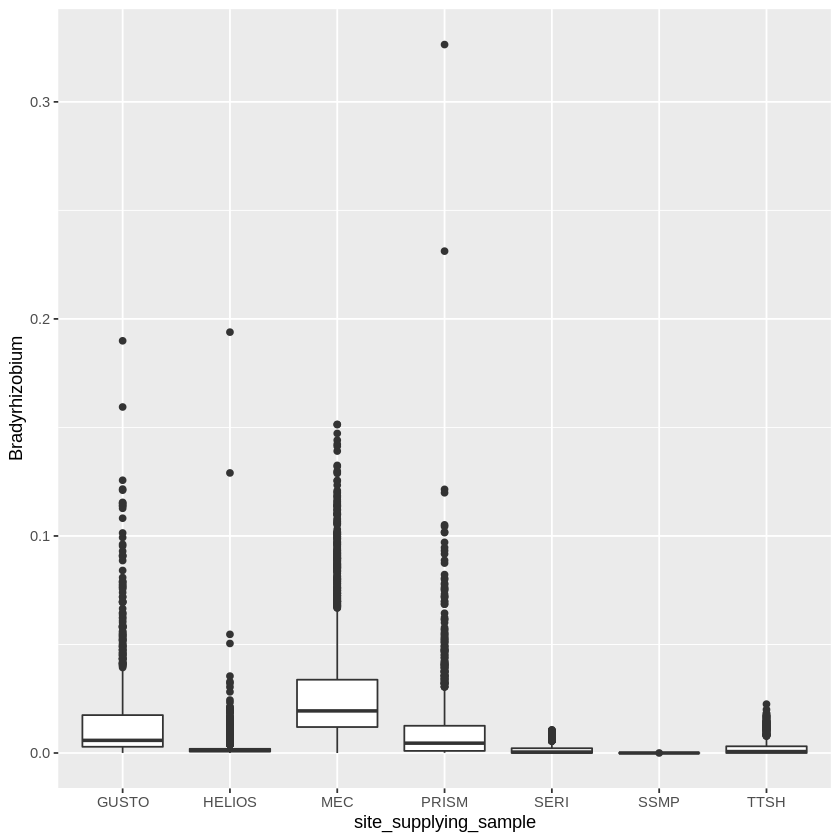

In [155]:
prev_genus %>%
    left_join(meta) %>%
    ggplot(aes(x = site_supplying_sample, y = Bradyrhizobium)) +
    geom_boxplot()

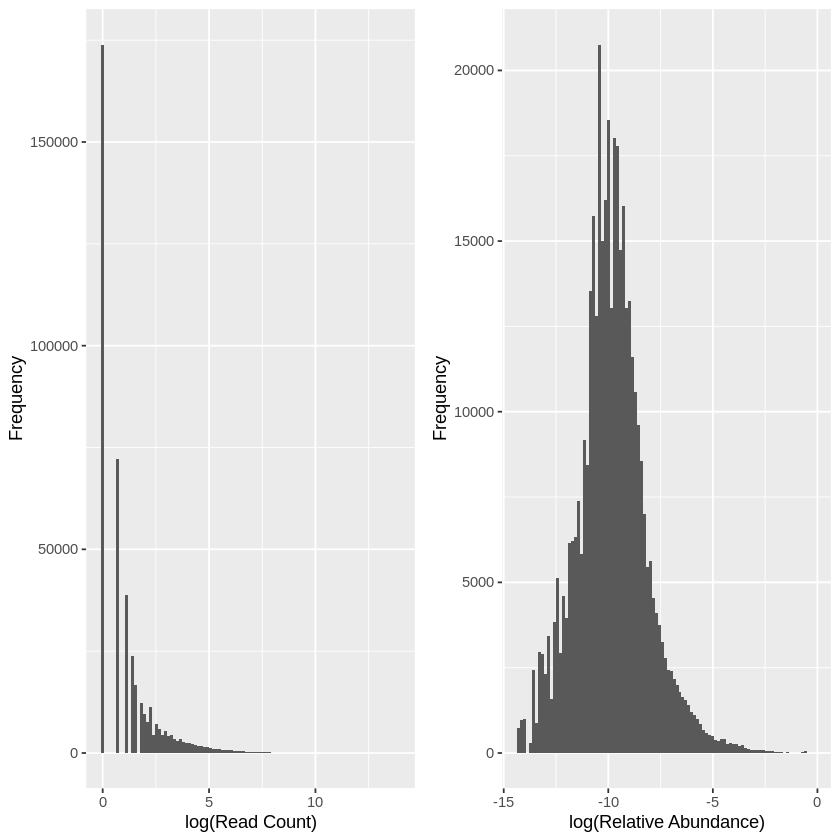

In [66]:
frac <- 0.1
RA_long <- species_RA %>%  
    sample_frac(frac) %>%
    select(-npm_research_id, -"Homo sapiens", -unclassified) %>%
    pivot_longer(everything(), names_to = "taxa", values_to = "rel_a") %>%
    filter(rel_a != 0) %>% 
    arrange(desc(rel_a))

RA_plt <- RA_long %>%
    ggplot(aes(x = log(rel_a))) +
    geom_histogram(bins = 100) +
    labs(x = "log(Relative Abundance)", y = "Frequency")

species_long <- species_df %>%
    sample_frac(frac) %>%
    select(-npm_research_id, -"Homo sapiens", -unclassified) %>%
    pivot_longer(everything(), names_to = "taxa", values_to = "read_count") %>%
    filter(read_count != 0) %>% 
    arrange(desc(read_count))

read_plt <- species_long %>%
    ggplot(aes(x = log(read_count))) +
    geom_histogram(bins = 100) +
    labs(x = "log(Read Count)", y = "Frequency")

ggarrange(read_plt, RA_plt, ncol = 2)

In [93]:
sorted_df <- RA_long %>%
    filter(rel_a != 0) %>%
    group_by(taxa) %>%
    summarise(median = median(rel_a), min = min(rel_a), max = max(rel_a)) %>%
    arrange(desc(median))
head(sorted_df)

taxa,median,min,max
<chr>,<dbl>,<dbl>,<dbl>
Human betaherpesvirus 6A,0.065983860,1.095457e-04,0.612705061
Alcaligenes faecalis,0.044210044,1.240929e-06,0.446127012
Alcaligenes aquatilis,0.003552924,1.459577e-06,0.026718465
Sphingomonas melonis,0.001359863,2.659018e-06,0.037800238
Acinetobacter johnsonii,0.001329429,6.204644e-07,0.008459689
Methylobacterium currus,0.001265422,3.323772e-06,0.012472545


In [132]:
prev_dat <- species_RA
prev_dat[prev_dat > 0] <- 1

In [134]:
prev_stats <- apply(prev_dat[, 2:ncol(prev_dat)], 2, sum) / nrow(prev_dat)
prev_df <- data.frame(taxa = names(prev_stats), prevalence = as.vector(prev_stats))
prev_df %>% arrange(desc(prevalence))

taxa,prevalence
<chr>,<dbl>
unclassified,1.0000000
Homo sapiens,1.0000000
Xanthomonas euvesicatoria,0.8746136
Bradyrhizobium sp. SK17,0.8101175
Altererythrobacter sp. B11,0.8089841
Rhodopseudomonas palustris,0.7929116
Cutibacterium acnes,0.7771482
Bradyrhizobium erythrophlei,0.7688028
Ralstonia insidiosa,0.7390274


In [137]:
# to_show <- c(head(sorted_df)$taxa, sorted_df$taxa[grep("Stenotrophomonas", sorted_df$taxa)])
to_show <- sorted_df$taxa[grep("Moraxella oslo|Nocardia", sorted_df$taxa)]
sorted_df %>% 
filter(taxa %in% to_show) %>%
left_join(prev_df) %>%
arrange(desc(prevalence))

Joining, by = "taxa"



taxa,median,min,max,prevalence
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Moraxella osloensis,9.802693e-05,6.204644e-07,0.0578591173,0.4908304
Nocardia brasiliensis,3.647335e-05,7.993292e-07,0.0004986702,0.3097053
Nocardia farcinica,3.734864e-05,1.330987e-06,0.0004310345,0.2972388
Nocardia sp. CFHS0054,3.103566e-05,1.280257e-06,0.0002286760,0.2748815
Nocardia cyriacigeorgica,2.832059e-05,1.486525e-06,0.0001939864,0.2603544
Nocardia seriolae,2.905162e-05,1.280257e-06,0.0001800828,0.2599423
Nocardia terpenica,2.233788e-05,1.289913e-06,0.0002784223,0.2221306
Nocardia sp. Y48,2.362112e-05,7.643787e-07,0.0002118644,0.2078096
Nocardia asteroides,2.337813e-05,7.643787e-07,0.0002471577,0.2026581


In [150]:
nc <- read.csv("results/decontamination/prevalence.noncontam.S.n9999.txt")
nc

non_contaminants
<chr>
Ralstonia insidiosa
Bradyrhizobium sp. SK17
Bradyrhizobium erythrophlei
Rhodopseudomonas palustris
Methylorubrum populi
Agrobacterium tumefaciens
Altererythrobacter sp. B11
Cutibacterium acnes
Sphingobium sp. YG1


In [147]:
sorted_df %>% 
left_join(prev_df) %>%
arrange(desc(prevalence)) %>%
mutate(above_t = ifelse(prevalence > 0.5, "prev_above_50", "prev_below_50")) %>%
mutate(text_annot = ifelse(above_t == "prev_above_50", taxa, "")) %>%
recode(text_annot ==)

Joining, by = "taxa"



taxa,median,min,max,prevalence,above_t,text_annot
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
Xanthomonas euvesicatoria,0.0001600132,6.616586e-06,0.0065634467,0.8746136,prev_above_50,Xanthomonas euvesicatoria
Bradyrhizobium sp. SK17,0.0010258887,1.661886e-05,0.1105115316,0.8101175,prev_above_50,Bradyrhizobium sp. SK17
Altererythrobacter sp. B11,0.0001772735,1.280257e-06,0.0026389463,0.8089841,prev_above_50,Altererythrobacter sp. B11
Rhodopseudomonas palustris,0.0005416385,1.639774e-05,0.0331171048,0.7929116,prev_above_50,Rhodopseudomonas palustris
Cutibacterium acnes,0.0001596424,1.644099e-06,0.0130197954,0.7771482,prev_above_50,Cutibacterium acnes
Bradyrhizobium erythrophlei,0.0003183362,7.977053e-06,0.0236713327,0.7688028,prev_above_50,Bradyrhizobium erythrophlei
Ralstonia insidiosa,0.0001804367,1.314435e-06,0.4605138781,0.7390274,prev_above_50,Ralstonia insidiosa
Agrobacterium tumefaciens,0.0001787011,4.196321e-06,0.0146573775,0.7272821,prev_above_50,Agrobacterium tumefaciens
Bradyrhizobium sp. BTAi1,0.0002615225,7.977053e-06,0.0156912124,0.6997733,prev_above_50,Bradyrhizobium sp. BTAi1


Joining, by = "taxa"



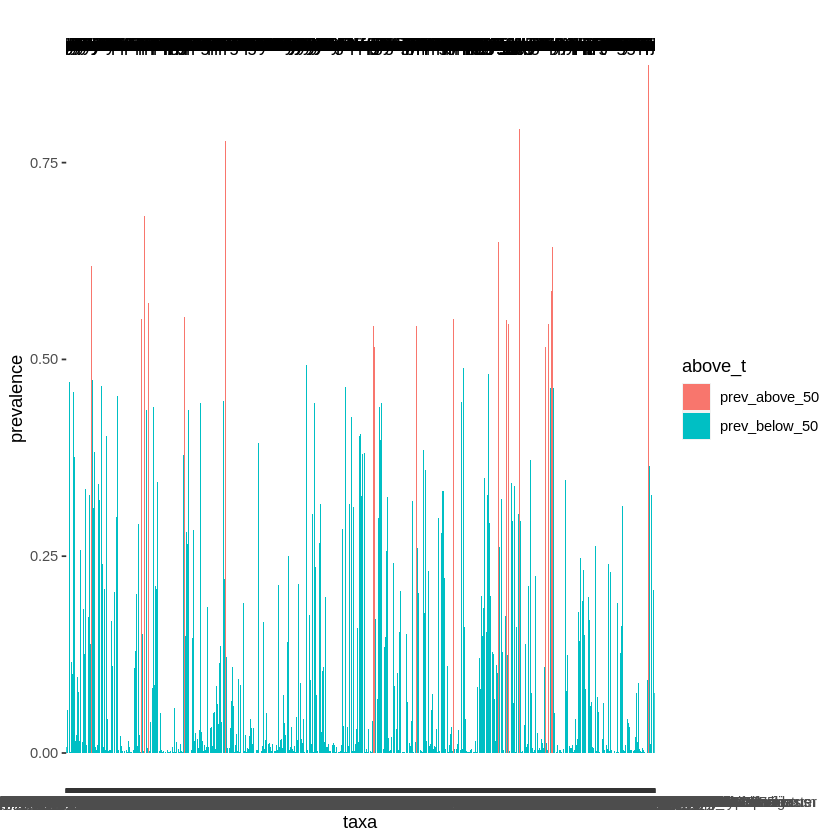

In [146]:
sorted_df %>% 
left_join(prev_df) %>%
arrange(desc(prevalence)) %>%
mutate(above_t = ifelse(prevalence > 0.5, "prev_above_50", "prev_below_50")) %>%
mutate(text_annot = ifelse(above_t == "prev_above_50", taxa, "")) %>%
ggplot(aes(x = taxa, y = prevalence, fill = above_t)) +
geom_bar(stat = "identity") +
geom_text(aes(x = taxa, y = 0.9, label = text_annot))

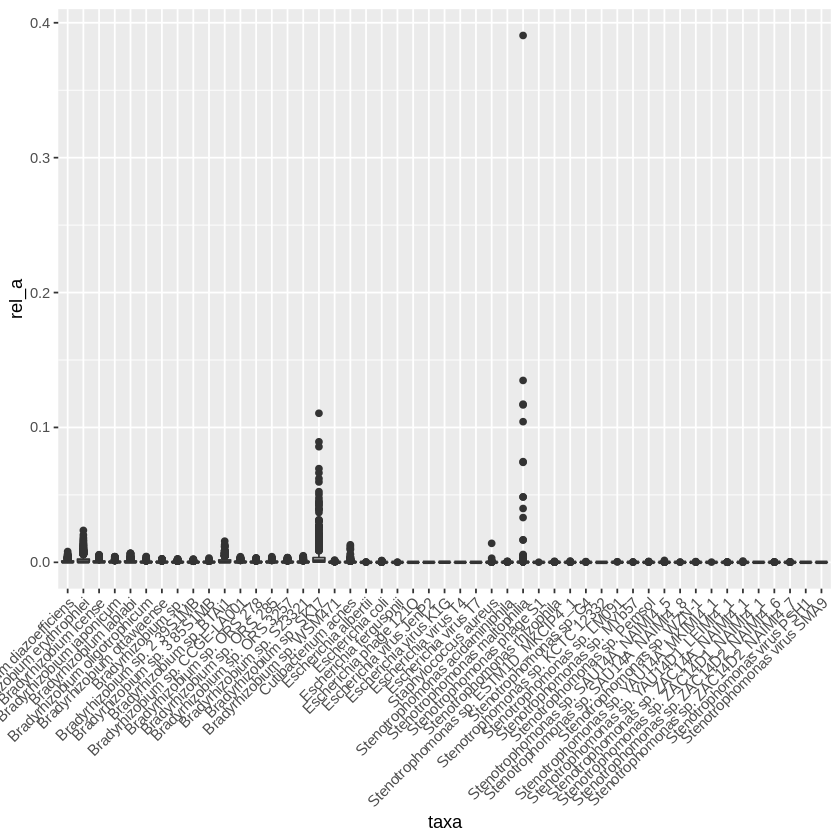

In [82]:
to_keep <- c("Cutibacterium acnes", "Staphylococcus aureus", "Escherichia", "Stenotrophomonas", "Bradyrhizobium")
to_search <- paste0(to_keep, collapse = "|")
RA_long %>% 
    filter(grepl(to_search, taxa)) %>%
    ggplot(aes(x = taxa, y = rel_a)) +
    geom_boxplot() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))

#### Prop unclassified

In [5]:
species_RA <- t(apply(species_df %>% column_to_rownames("npm_research_id"), 1, function(x) {x / sum(x)}))
species_RA <- as_tibble(species_RA)

[1] 9706

Saving 6.67 x 6.67 in image



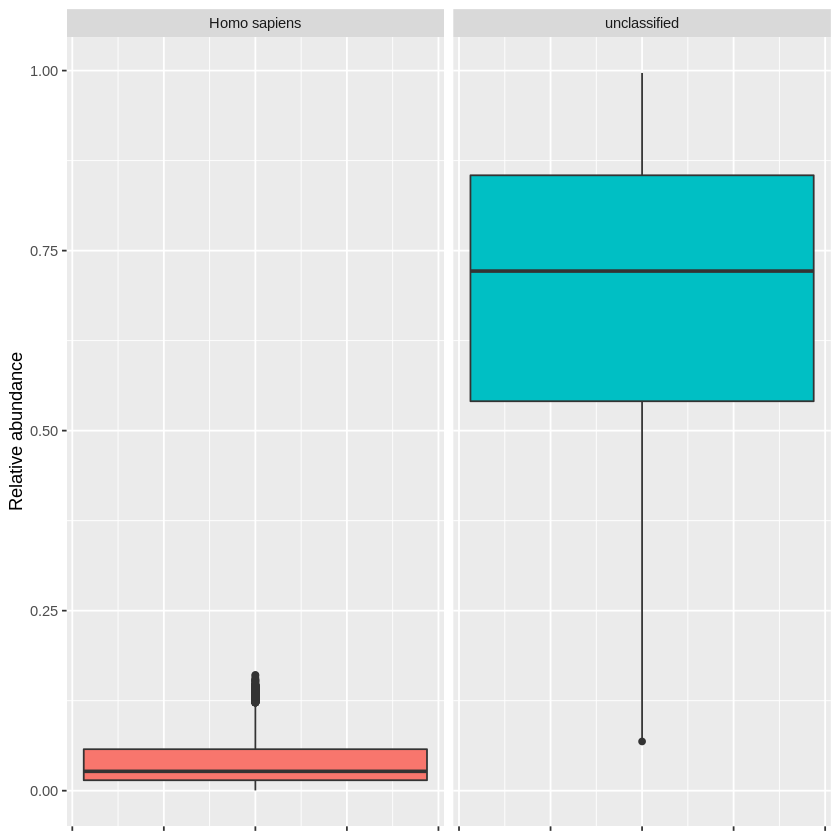

In [6]:
nrow(species_RA)
species_RA %>% 
    select(unclassified, "Homo sapiens") %>%
    pivot_longer(everything(), names_to = "taxa", values_to = "abundance") %>%
    ggplot(aes(y = abundance, fill = taxa, groups = taxa)) +
    geom_boxplot() +
    facet_grid(cols = vars(taxa)) +
    theme(legend.position = "None",
          axis.text.x = element_blank()) +
    labs(y = "Relative abundance")

ggsave("results/unclassified_and_human_boxplot.png", dpi = 300)

#### Heatmap

In [60]:
species_RA_parsed <- species_RA %>% 
    rownames_to_column("npm_research_id") %>%
    sample_n(500, replace = F)

long_df <- species_RA_parsed %>% 
    pivot_longer(!npm_research_id, names_to = "taxa", values_to = "abundance") %>%
    mutate(abundance = ifelse(abundance == 0, NA, abundance)) %>%
    mutate(abundance = log(abundance))

In [61]:
sample_clust <- hclust(dist(species_RA_parsed, method = "euclidean"), method = "ward.D" )$order
taxa_clust <- hclust(dist(t(species_RA_parsed), method = "euclidean"), method = "ward.D" )$order
long_df <- long_df %>% 
    mutate(npm_research_id = factor(npm_research_id, levels = species_RA_parsed$npm_research_id[clust]),
           taxa = factor(taxa, levels = colnames(species_RA_parsed)[taxa_clust]))

Saving 6.67 x 6.67 in image



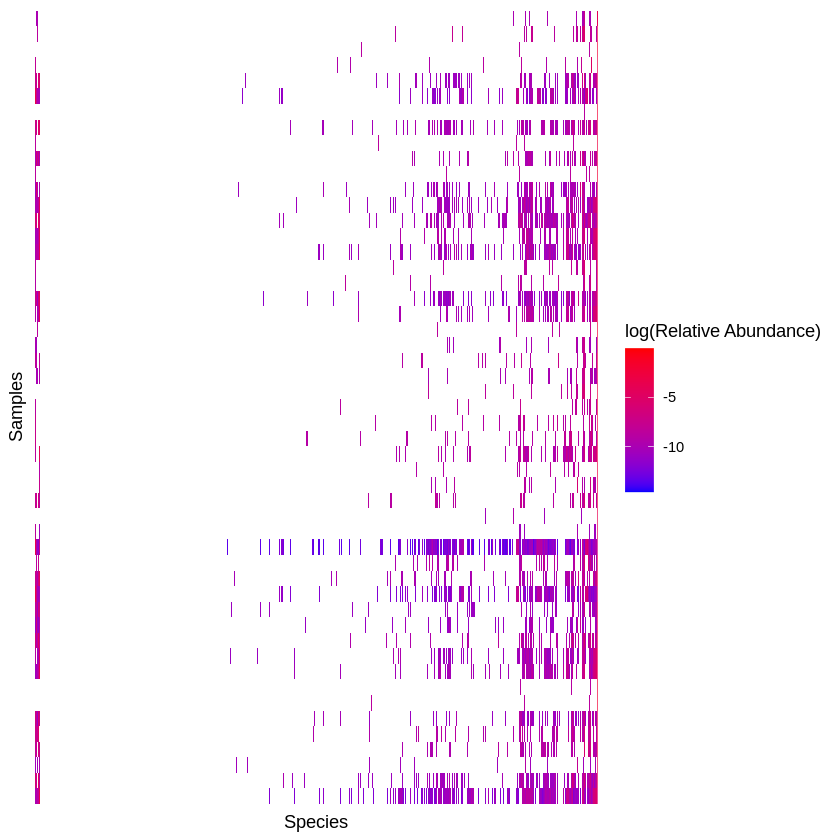

In [63]:
hm <- long_df %>%
    ggplot(aes(x = taxa, y = npm_research_id, fill = abundance)) +
    geom_tile() +
    scale_fill_gradient(na.value = "white", low = "blue", high = "red") +
    theme(axis.text = element_blank(),
         axis.ticks = element_blank()) +
    labs(x = "Species", y = "Samples", fill = "log(Relative Abundance)")

hm

ggsave("results/relative_abundance_heatmap.png", dpi = 300, plot = hm)

### Count and remove samples with no classified reads
This may include samples that originally had no reads, and samples whose reads cannot be classified

In [5]:
count_zero_reads <- function(df) {
    df %>%
        rowwise() %>%
        mutate(total = sum(across(everything()))) %>%
        filter(total == 0) %>%
        nrow()
    }

count_zero_reads(species_df)

[1] 0

### Normalise to relative abundance

In [6]:
normalise <- function(df) {
    RA_df <- t(apply(df, 1, function(x) {x / sum(x) * 100}))
    return(RA_df)
}

species_RA <- normalise(species_df)
species_RA

,unclassified,Homo sapiens,Bradyrhizobium sp. SK17,Bradyrhizobium lablabi,Bradyrhizobium ottawaense,Bradyrhizobium sp. ORS 3257,Bradyrhizobium oligotrophicum,Bradyrhizobium sp. ORS 285,Bradyrhizobium sp. BTAi1,Bradyrhizobium icense,⋯,Virgibacillus dokdonensis,Lactobacillus sp. wkB8,Candidatus Mikella endobia,Pseudoalteromonas espejiana,Candidatus Blochmannia floridanus,Pragia fontium,Vibrio nigripulchritudo,Propionibacterium virus ATCC29399BC,Mycobacterium virus Bane1,Gordonia phage Nyceirae
MUX9276.WHB4733,95.95763,2.6880050,0.681064844,0.0051792003,0.005179200,0.005179200,0.005179200,0.002589600,0.00258960,0.002589600,⋯,0,0,0,0,0,0,0,0,0,0
SSMP_001_to_009.SSM009,96.65738,3.0640669,0.000000000,0.0000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.00000000,0.000000000,⋯,0,0,0,0,0,0,0,0,0,0
MUX8330.WHB5084,23.05727,1.2760900,0.964123895,0.0089133180,0.011884424,0.014855530,0.011884424,0.016341083,0.02079774,0.019312189,⋯,0,0,0,0,0,0,0,0,0,0
MUX5236.WHB840,90.05682,8.4353147,0.415209790,0.0000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.00000000,0.021853147,⋯,0,0,0,0,0,0,0,0,0,0
MUX5341.WHB979,86.64691,5.2732502,0.000000000,0.0000000000,0.000000000,0.008716116,0.000000000,0.000000000,0.00000000,0.000000000,⋯,0,0,0,0,0,0,0,0,0,0
MUX4127.WHH1895,85.94428,13.4949349,0.000000000,0.0000000000,0.000000000,0.018089725,0.000000000,0.000000000,0.00000000,0.000000000,⋯,0,0,0,0,0,0,0,0,0,0
MUX5185.WHB711,89.75365,9.7013298,0.000000000,0.0000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.00000000,0.000000000,⋯,0,0,0,0,0,0,0,0,0,0
MUX9967.WHB7729,92.06035,2.2924451,0.003166361,0.0000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.00158318,0.000000000,⋯,0,0,0,0,0,0,0,0,0,0
MUX9038.WHB4012,89.31582,3.7331513,0.027299096,0.0034123870,0.000000000,0.000000000,0.006824774,0.003412387,0.01706193,0.013649548,⋯,0,0,0,0,0,0,0,0,0,0
MUX10691.WHB11068,52.49687,1.3024684,0.298600842,0.2075986805,0.076783074,0.082470709,0.082470709,0.127971789,0.36116483,0.190535775,⋯,0,0,0,0,0,0,0,0,0,0


## Relative abundance for all samples

### Matrix --> long format

In [7]:
to_long_format <- function(RA_df) {
    plot_df <- as_tibble(RA_df, rownames = "sample") %>%
        pivot_longer(!sample, names_to = "rank", values_to = "abundance")
    return(plot_df)
    }

plot_species_RA <- to_long_format(species_RA)

### Keep only top N ranks
ranked by median relative abundance

In [8]:
get_top_N_ranks <- function(plot_df, n_keep) {
    ranks_to_keep <- plot_df %>% 
        group_by(rank) %>%
        summarise(median = median(abundance)) %>%
        arrange(desc(median))
      ranks_to_keep <- ranks_to_keep$rank[1:n_keep]
    return(ranks_to_keep)
}

n_keep <- 8
species_to_keep <- get_top_N_ranks(plot_species_RA, n_keep)

### Visualise relative abundances

Define palette

In [9]:
pal <- c("#d1495b", "#00798c", "#edae49", 
         "#66a182", "#2e4057", "#8d96a3",
         "#8E44AD", "#2980b9")

Order by total percentage of top taxa

In [27]:
get_sample_order <- function(plot_df, species_to_keep) {
    ordered_df <- plot_df %>%
        filter(rank %in% species_to_keep) %>%
        group_by(sample) %>%
        summarise(total = sum(abundance)) %>% 
        arrange(desc(total))

    taxa_order <- ordered_df$sample
    return(taxa_order)
}

sample_order <- get_sample_order(plot_species_RA, species_to_keep)

Plot

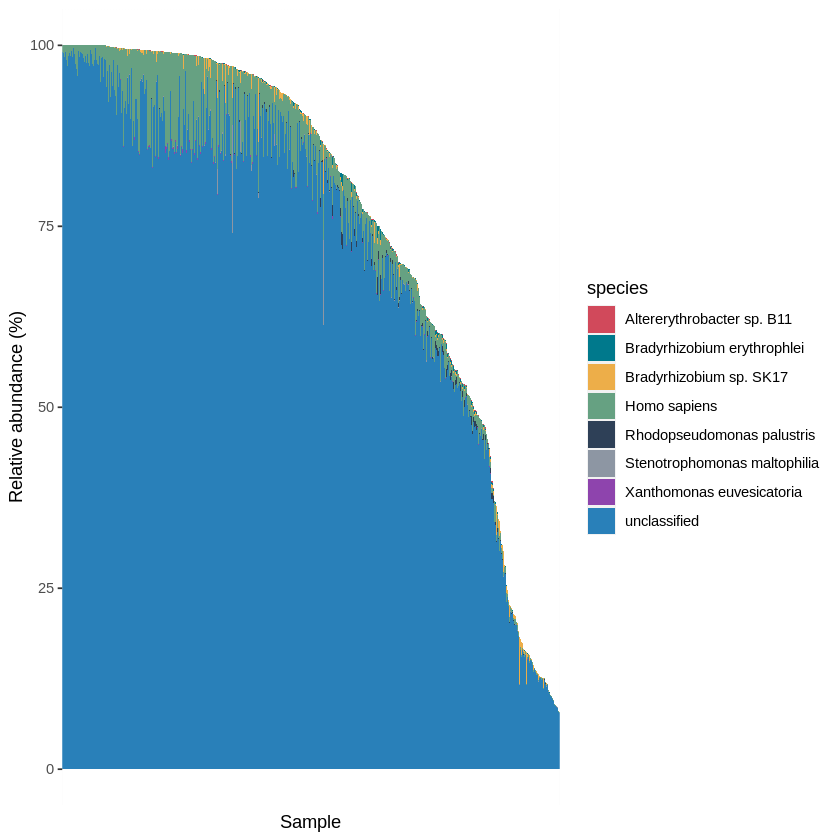

In [29]:
get_plot <- function(plot_df, ranks_to_keep, rank_name, sample_order) {
    plt <- plot_df %>%
        filter(rank %in% ranks_to_keep) %>%
        mutate(sample = factor(sample, levels = sample_order)) %>%
        ggplot(aes(x = sample, y = abundance, fill = rank)) +
            geom_bar(stat = "identity", position = "stack") +
            labs(x = "Sample", y = "Relative abundance (%)", fill = rank_name) +
            theme(axis.text.x = element_blank(),
                  axis.ticks.x = element_blank()) +
            scale_fill_manual(values = pal[1:n_keep])
    return(plt)
}

# get_plot(plot_family_RA, family_to_keep, "family")
# get_plot(plot_genus_RA, genus_to_keep, "genus")
get_plot(plot_species_RA, species_to_keep, "species", sample_order)

Rather heterogenous

## Relative abundance by cohort

### Add metadata, groupby cohort and --> long format

In [36]:
parse_cohort_data <- function(RA_df) {
    plot2_df <- as_tibble(RA_df, rownames = "sample") %>%
        separate(sample, into = c(NA, "npm_research_id"), sep = "\\.") %>%
        left_join(meta, by = "npm_research_id")
    
    plot2_df <- plot2_df %>%
    group_by(source_cohort) %>%
    summarise(across(where(is.numeric), ~ mean(.x, na.rm = T))) %>%
    pivot_longer(!source_cohort, names_to = "rank", values_to = "abundance")
}

# cohort_family_RA <- parse_cohort_data(family_RA)
# cohort_genus_RA <- parse_cohort_data(genus_RA)
cohort_species_RA <- parse_cohort_data(species_RA)

### Visualise

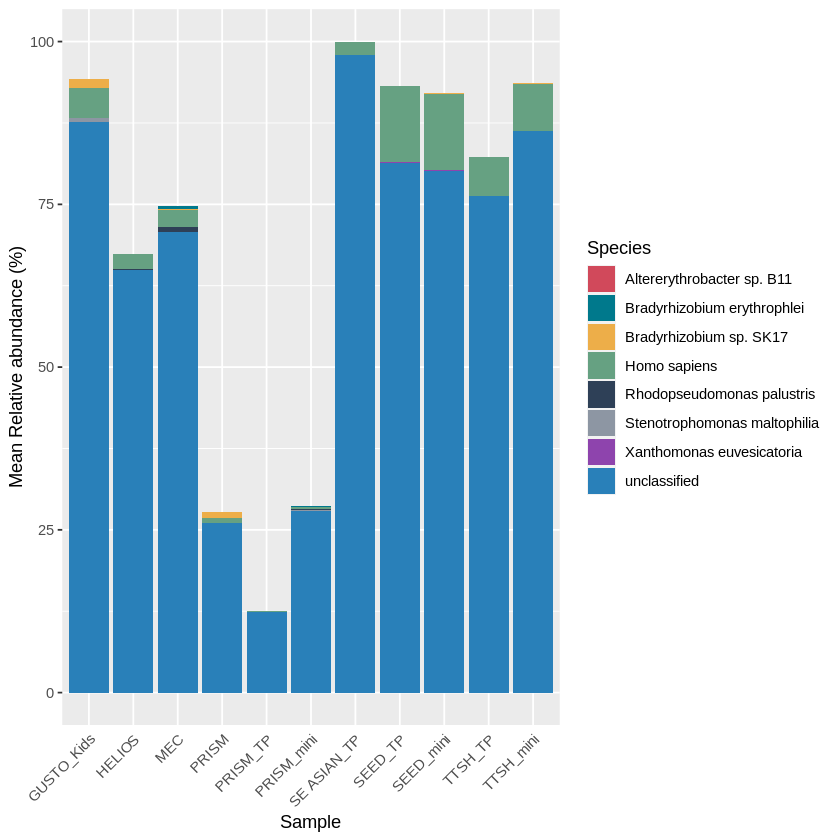

In [38]:
get_cohort_plt <- function(plot2_df, ranks_to_keep, rank_name) {
    plt <- plot2_df %>%
        filter(rank %in% ranks_to_keep) %>%
    #     mutate(sample = factor(sample, levels = unique(sample)[order(sample)])) %>%
        ggplot(aes(x = source_cohort, y = abundance, fill = rank)) +
            geom_bar(stat = "identity", position = "stack") +
            labs(x = "Sample", y = "Mean Relative abundance (%)", fill = rank_name) +
            theme(axis.text.x = element_text(angle = 45, hjust = 1),
                  axis.ticks.x = element_blank()) +
            scale_fill_manual(values = pal[1:n_keep])
    return(plt)
}

# get_cohort_plt(cohort_family_RA, family_to_keep, "Family")
# get_cohort_plt(cohort_genus_RA, genus_to_keep, "Genus")
get_cohort_plt(cohort_species_RA, species_to_keep, "Species")